# Loading and graphing the HILDA dataset  
This notebook is just to provide a simple intro to working with HILDA data in Python 3.  We will need pandas to extract the data from the STATA files, and seaborn to plot a few numeric variables from HILDA (`losat`, `ghmh`).

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

We have sixteen STATA SE13 files here, one for each year from 2001 to 2016. 

In [2]:
hildafilelist = glob.glob('../data/*.dta')
hildafilelist.sort()
hildafilelist

['../data/Combined_a160c.dta',
 '../data/Combined_b160c.dta',
 '../data/Combined_c160c.dta',
 '../data/Combined_d160c.dta',
 '../data/Combined_e160c.dta',
 '../data/Combined_f160c.dta',
 '../data/Combined_g160c.dta',
 '../data/Combined_h160c.dta',
 '../data/Combined_i160c.dta',
 '../data/Combined_j160c.dta',
 '../data/Combined_k160c.dta',
 '../data/Combined_l160c.dta',
 '../data/Combined_m160c.dta',
 '../data/Combined_n160c.dta',
 '../data/Combined_o160c.dta',
 '../data/Combined_p160c.dta']

The entire dataset is approx 12GB if loaded into memory, which takes about 1.5 minutes on my machine using the code below. Loading the entire dataset into memory is the fastest way to work on it if you need  to explore variables spanning the sixteen years, because you only need to import the dataset once and further operations on any specific variables are very quick. But it comes at a large cost to memory.

In [18]:
%%time
dflist = []
for pathtofile in hildafilelist:
    df = pd.read_stata(pathtofile, convert_categoricals=False)
    dflist.append(df)

print(len(dflist))  

16
CPU times: user 1min 26s, sys: 7.3 s, total: 1min 33s
Wall time: 1min 19s


However the aim of this notebook is to show how to access the variables without committing 12GB of memory to a single object. So below I use a function `GetVars` which can extract named variables from the Stata files without loading the entire dataset into memory.

The function below (`GetVars`) extracts a set of variables (provided as a tuple) and returns a  pandas dataframe, with individuals down the rows and variables across columns. The key to its magic is the use of a dictionary created by the `pd.read_stata` function, which can read the variable names in each Stata file without loading it. As long as we know the name of the variables we want, then it should be faster and less memory intensive than loading the entire dataset. 

*(however as soon as you start exploring futher variables, and so executing more load functions, it quickly becomes less efficient than loading the entire dataset once)*

Each year in the dataset is termed a "wave" and each wave is given a letter rather than a number (**`a`** to **`p`**) to identify it (i.e., the `waveid`). The `waveid` precedes every variable code in the dataset, which makes iterating over waves difficult.  

In [3]:
def GetVars(flist, codetuple):
    ''' Return a new df with values of the hilda variable from every wave'''

    for fpath in flist:
        # Read all the variable names and labels in the current wave
        fdictionary = pd.read_stata(fpath, iterator = True)
        vnames = fdictionary.varlist
        
        # Get the variable names we want in the current wave
        varwavenames = [var for var in vnames if var.endswith(codetuple)]
        varwavenames.insert(0, "xwaveid")
        
        # Store the waveid (for recording below)
        waveid = varwavenames[-1][0]
        
        # Extract the variables we want
        df = pd.read_stata(fpath,
                           index_col = "xwaveid",
                           columns = varwavenames,
                           convert_categoricals = False
                           )
        
        # Relabel the columns to remove the waveid from each variable
        df.columns = df.columns.str.replace(r"^[a-p]", "")
        
        # Record the waveid in its own variable
        df = df.assign(wave = waveid)
        
        # Concatenate the new dataframe with the results so far
        try:
            joined = pd.concat([joined, df])
            
        except NameError:
                joined = df.copy()
                                
    return joined

As an example, we will extract 1, 2, and 4 variables from the entire dataset. The time taken does not increase with the number of variables extracted.

In [4]:
%%time
hildavar = ('losat') # Nb: HILDA variable codes provided as a tuple
hildadf = GetVars(hildafilelist, hildavar)
print(hildadf.shape) # (317738, 2) total: 33.9 s

(317738, 2)
CPU times: user 32.5 s, sys: 3.67 s, total: 36.2 s
Wall time: 24 s


In [5]:
%%time
hildavar = ('losat', 'losatyh') 
hildadf = GetVars(hildafilelist, hildavar)
print(hildadf.shape) # (317738, 3) total: 33.7 s

(317738, 3)
CPU times: user 32.2 s, sys: 3.76 s, total: 36 s
Wall time: 24 s


In [6]:
%%time
hildavar = ('losat', 'losatyh','ghmh', 'hgage') 
hildadf = GetVars(hildafilelist, hildavar)
print(hildadf.shape) # (317738, 5) total: 37.7 s

(317738, 5)
CPU times: user 33.2 s, sys: 3.74 s, total: 36.9 s
Wall time: 24.2 s


In [7]:
hildadf.head() # This is what the result looks like

,hgage,losatyh,losat,ghmh,wave
xwaveid,,,,,
0100001,49,5,8,72.0,a
0100002,48,4,7,64.0,a
0100003,48,8,10,92.0,a
0100004,38,10,10,64.0,a
0100005,16,10,10,100.0,a


In [8]:
hildadf.wave.unique() # There are sixteen waves included in the result

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p'], dtype=object)

In [9]:
hildadf.isna().sum() # There are no missing values 

hgage      0
losatyh    0
losat      0
ghmh       0
wave       0
dtype: int64

In [10]:
hildadf.groupby('losat').count() # Missing values are coded as negative in HILDA

,hgage,losatyh,ghmh,wave
losat,,,,
-10,82127,82127,82127,82127
-4,88,88,88,88
-3,76,76,76,76
0,326,326,326,326
1,404,404,404,404
2,919,919,919,919
3,1722,1722,1722,1722
4,2811,2811,2811,2811
5,9767,9767,9767,9767


In [11]:
# Replacing the negative (missing) values with NaN
hildadf.loc[ hildadf['losat'] < 0] = np.nan
hildadf.loc[ hildadf['ghmh'] < 0] = np.nan
hildadf.loc[ hildadf['losatyh'] < 0] = np.nan
hildadf.groupby('losat').count() 

,hgage,losatyh,ghmh,wave
losat,,,,
0.0,253,253,253,253
1.0,336,336,336,336
2.0,760,760,760,760
3.0,1433,1433,1433,1433
4.0,2367,2367,2367,2367
5.0,8173,8173,8173,8173
6.0,11926,11926,11926,11926
7.0,39627,39627,39627,39627
8.0,70977,70977,70977,70977


Plotting across the sixteen waves (a-p)

In [13]:
# Rescaling ghmh to compare on same scale
hildadf["ghmh"] = (
    (hildadf["ghmh"] - hildadf["ghmh"].min())
    /
    (hildadf["ghmh"].max() - hildadf["ghmh"].min())
    ) * 10

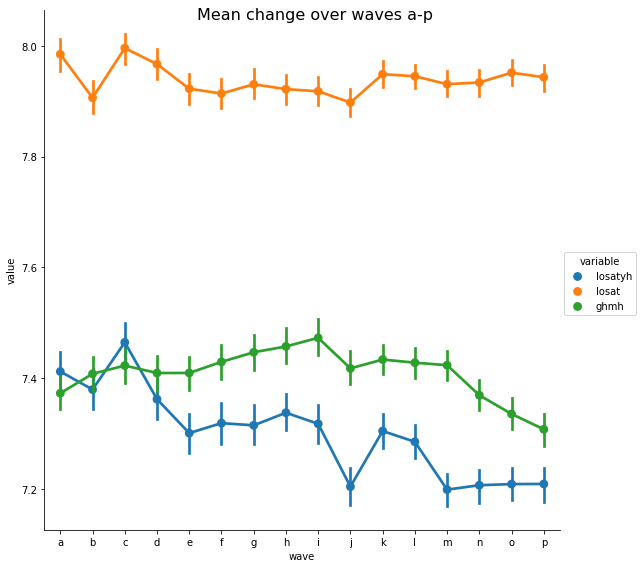

In [14]:
# Some reshaping to plot in seaborn
plotdf = hildadf.melt(id_vars = ('wave'))


%matplotlib inline
g = sns.factorplot(x = 'wave', 
                   y = 'value',
                   hue = 'variable',
                   data = plotdf[plotdf.variable != 'hgage'], 
                   size = 8)
g.fig.suptitle("Mean change over waves a-p", fontsize = 16)
plt.show()

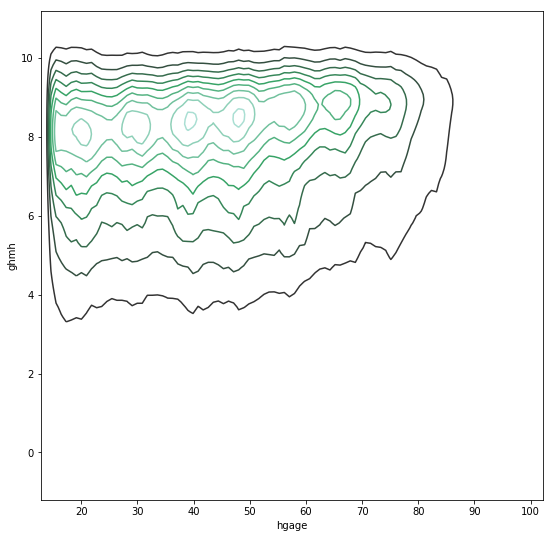

In [16]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 9]
plotdf = hildadf.dropna()
sns.kdeplot(plotdf.hgage, plotdf.ghmh, bw = .4)